# Final Project Report

* Class: DS 5100
* Student Name: Luke Napolitano
* Student Net ID: ljn5yms
* This URL: https://github.com/lnap24/DS5100-finalproject-ljn5yms/blob/main/DS5100_FinalProject.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/lnap24/DS5100-finalproject-ljn5yms

Paste a copy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```
from random import sample
import numpy as np
import pandas as pd
class Die():
    
    def __init__(self, sides):
        if type(sides) != np.ndarray:
            raise TypeError("The input must be a numpy array")
        if len(sides) != len(set(sides)):
            raise ValueError("Array values are not unique")
        if not np.issubdtype(sides.dtype, np.number) and not np.issubdtype(sides.dtype, np.str_):
            raise TypeError("The input array must have a data type of strings or numbers")
        self.sides = sides
        self.weights = np.ones(len(self.sides))
        self._die = pd.DataFrame({'side': self.sides, 'weight': self.weights/len(sides)})
    
    def side_weight_change(self, side, weight):
        if side not in self._die['side'].values:
            raise IndexError("The side does not exist")
        if weight < 0:
            raise ValueError("The weight must be greater than or equal to zero")
        if not np.issubdtype(type(weight), np.number):
            raise TypeError("The weight must be a number")
        self._die.loc[self._die['side'] == side, 'weight'] = weight
        self.weights = self._die['weight'].values
    
    def roll(self, nrolls):
        self.nrolls = 1
        total_weight = sum(self.weights)
        normalized_weights = [w / total_weight for w in self.weights]
        outcomes = np.random.choice(self._die['side'].values, size=nrolls, replace=True, p=normalized_weights)
        return list(outcomes)
    
    def current_state(self):
        return self._die  
class Game():
    
    def __init__(self, dice):
        if type(dice) != list:
            raise TypeError("The input must be a list")
        self.dice = dice
        self.dice_df = pd.DataFrame({
            'dice_num': range(1, len(dice) + 1),
            'die': dice
        })
        self._nrolls = None
        self._gamedf = pd.DataFrame()
    
    def play(self, die_number, nrolls):
        if self._nrolls is None:
            self._nrolls = nrolls
        elif self._nrolls != nrolls:
            raise ValueError(f"Incompatible number of rolls: {nrolls} provided, but {self._nrolls} expected")
        
        spec_die = self.dice[die_number - 1]  # Access the specific die by index (adjusting for 1-based indexing)
        rolls = spec_die.roll(nrolls)
        
        # Create a DataFrame to store the results in wide format
        roll_df = pd.DataFrame({
            'roll_number': range(1, nrolls + 1),
            f'die_{die_number}': rolls
        }).set_index('roll_number')
        
        # Combine with existing _gamedf
        if self._gamedf.empty:
            self._gamedf = roll_df
        else:
            self._gamedf = self._gamedf.join(roll_df, how='outer')
        
        return self._gamedf
        
    def results(self, form = 'wide'):
        self.form = form
        if self.form == 'wide':
            return self._gamedf
        elif self.form == 'narrow':
            return self._gamedf.melt(ignore_index=False)
        else:
            raise ValueError("Invalid option for form")   
class Analyzer():
    
    def __init__(self, game):
        if type(game) != Game:
            raise TypeError("The input must be a Game object")
        self.game = game
        self._gamedf = game._gamedf
        self.nrolls = len(game._gamedf) 
        self.jackpot_counter = 0
        self.die_sides = self.game.dice[0].sides

    def jackpot(self):
        for index, row in self._gamedf.iterrows():
            if len(set(row)) == 1:  # Check if all non-NaN values in the row are the same
                self.jackpot_counter += 1
        return self.jackpot_counter
    
    def face_count(self):
        counts = []
        for _, row in self.game._gamedf.iterrows():
            count = row.value_counts().reindex(self.die_sides, fill_value=0)
            counts.append(count)
        counts_df = pd.DataFrame(counts, index=self.game._gamedf.index).reset_index(drop=True)
        return counts_df
        
    def combo_count(self):
        #computes distinct combinations of faces rolled
        combos = []
        for _, row in self.game._gamedf.iterrows():
            combo = tuple(sorted(row.dropna()))
            combos.append(combo)
        combo_counts = pd.Series(combos).value_counts().reset_index()
        combo_counts.columns = ['combination', 'count']
        combo_counts.set_index('combination', inplace=True)
        return combo_counts
    
    def perm_count(self):
        #computes distinct permutations of faces rolled
        perms = []
        for _, row in self.game._gamedf.iterrows():
            perm = tuple(row.dropna())
            perms.append(perm)
        perm_counts = pd.Series(perms).value_counts().reset_index()
        perm_counts.columns = ['permutation', 'count']
        perm_counts.set_index('permutation', inplace=True)
        return perm_counts

```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```
import unittest
import pandas as pd
import numpy as np
from montecarlo.montecarlo import *
from pandas.testing import assert_frame_equal

class MonteCarloTestSuite(unittest.TestCase):
    
    def test_die_init(self):
        my_test = Die(np.array([1,2,3,4,5,6]))
        expected = pd.DataFrame({'side': my_test.sides, 'weight': my_test.weights/len(my_test.sides)})
        # if true we have the correct data structure
        self.assertTrue(type(my_test._die) == type(expected))

    def test_die_side_weight_change(self):
        my_test = Die(np.array([1,2,3,4,5,6]))
        my_test.side_weight_change(1, 0.5)
        # if test is all good, the df was appropriately changed
        self.assertTrue(my_test._die.weight[0] == .5)

    def test_die_roll(self):
        my_test = Die(np.array([1,2,3,4,5,6]))
        my_test.roll(10)
        #if true, the output is a list of 10 rolls
        self.assertTrue(type(my_test.roll(10)) == list)
        self.assertTrue(len(my_test.roll(10)) == 10)

    def test_die_current_state(self):
        my_test = Die(np.array([1,2,3,4,5,6]))
        my_test.side_weight_change(2, 0.5)
        current_state = my_test.current_state()
        # if true, current state outputs the modified _die dataframe
        pd.testing.assert_frame_equal(current_state, my_test._die)
        
    def test_game_init(self):
        my_list = [Die(np.array([1,2,3,4,5,6])), Die(np.array([1,2,3,4,5,6]))]
        game = Game(my_list)
        # If true the created df has dice objects as the die column
        self.assertTrue(type(game.dice_df.die[0]) == Die)
        
    def test_game_play(self):
        my_list = [Die(np.array([1,2,3,4,5,6])), Die(np.array([1,2,3,4,5,6]))]
        game = Game(my_list)
        game.play(1, 5)
        # if true, the _gamedf has been modified once w/ appropriate number of rolls
        self.assertTrue(game._gamedf.shape[0] == 5)

    def test_game_results(self):
        my_list = [Die(np.array([1,2,3,4,5,6])), Die(np.array([1,2,3,4,5,6]))]
        game = Game(my_list)
        game.play(1, 5)
        game.play(2, 5)
        game.results()
        # if true, the game results df has the correct number of columns
        self.assertTrue(game.results().shape[1] == game._gamedf.shape[1])

    def test_analyzer_init(self):
        Die1 = Die(np.array([1,2,3,4,5,6]))
        Die2 = Die(np.array([1,2,3,4,5,6]))
        Die2.side_weight_change(1, 0.3)
        game = Game([Die1, Die2])
        game.play(1, 50)
        game.play(2, 50)
        analyzer = Analyzer(game)
        self.assertTrue(type(analyzer) == Analyzer)
        
    def test_analyzer_jackpot(self):
        Die1 = Die(np.array([1,2,3,4,5,6]))
        Die2 = Die(np.array([1,2,3,4,5,6]))
        game = Game([Die1, Die2])
        game.play(1, 50)
        game.play(2, 50)
        analyzer = Analyzer(game)
        analyzer.jackpot()
        self.assertTrue(type(analyzer.jackpot()) == int)

    def test_analyzer_face_count(self):
        Die1 = Die(np.array([1,2,3,4,5,6]))
        Die2 = Die(np.array([1,2,3,4,5,6]))
        game = Game([Die1, Die2])
        game.play(1, 50)
        game.play(2, 50)
        analyzer = Analyzer(game)
        faces = analyzer.face_count()
        self.assertTrue(len(faces.columns)==len(Die1.sides))

    def test_analyzer_combo_count(self):
        Die1 = Die(np.array([1,2,3,4,5,6]))
        Die2 = Die(np.array([1,2,3,4,5,6]))
        game = Game([Die1, Die2])
        game.play(1, 50)
        game.play(2, 50)
        analyzer = Analyzer(game)
        var1 = analyzer.combo_count()
        self.assertEqual(sum(var1['count']), game._nrolls)
        
    def test_analyzer_perm_count(self):
        Die1 = Die(np.array([1,2,3,4,5,6]))
        Die2 = Die(np.array([1,2,3,4,5,6]))
        game = Game([Die1, Die2])
        game.play(1, 50)
        game.play(2, 50)
        analyzer = Analyzer(game)
        var1 = analyzer.perm_count()
        self.assertEqual(sum(var1['count']), game._nrolls)

if __name__ == '__main__':
    
    unittest.main(verbosity=3)

```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

```
(base) Lukes-MacBook-Pro:DS5100-finalproject-ljn5yms Luke$ /usr/local/bin/python3 /Users/Luke/MSDS/DS5100-finalproject-ljn5yms/montecarlo_test.py
So Far, So Good
test_analyzer_combo_count (__main__.MonteCarloTestSuite) ... ok
test_analyzer_face_count (__main__.MonteCarloTestSuite) ... ok
test_analyzer_init (__main__.MonteCarloTestSuite) ... ok
test_analyzer_jackpot (__main__.MonteCarloTestSuite) ... ok
test_analyzer_perm_count (__main__.MonteCarloTestSuite) ... ok
test_die_current_state (__main__.MonteCarloTestSuite) ... ok
test_die_init (__main__.MonteCarloTestSuite) ... ok
test_die_roll (__main__.MonteCarloTestSuite) ... ok
test_die_side_weight_change (__main__.MonteCarloTestSuite) ... ok
test_game_init (__main__.MonteCarloTestSuite) ... ok
test_game_play (__main__.MonteCarloTestSuite) ... ok
test_game_results (__main__.MonteCarloTestSuite) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.104s

OK
(base) Lukes-MacBook-Pro:DS5100-finalproject-ljn5yms Luke$ 

```

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
import montecarlo.montecarlo 

So Far, So Good


## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [2]:
help(montecarlo.montecarlo)

Help on module montecarlo.montecarlo in montecarlo:

NAME
    montecarlo.montecarlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game)
     |  
     |  A class that analyzes game data.
     |  
     |  Attributes:
     |      game (Game): The game object to be analyzed.
     |      _gamedf (DataFrame): The game data as a pandas DataFrame.
     |      nrolls (int): The number of rolls in the game.
     |      jackpot_counter (int): The count of jackpot rolls.
     |      die_sides (int): The number of sides on each die.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game)
     |      Initializes an Analyzer object.
     |      
     |      Args:
     |          game (Game): The game object to be analyzed.
     |      
     |      Raises:
     |          TypeError: If the input is not a Game object.
     |  
     |  combo_count(self)
     |      Computes the count of distinct combi

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/lnap24/DS5100-finalproject-ljn5yms/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [2]:
from montecarlo.montecarlo import *

fair = Die(np.array(['H', 'T']))
unfair = Die(np.array(['H', 'T']))
unfair.side_weight_change('H', 5)
unfair.side_weight_change('T', 1)

So Far, So Good


In [3]:
die_test = Die(np.array(['H', 'T']))
die_test.roll(5)

['T', 'H', 'T', 'T', 'H']

In [12]:
fair._die

,side,weight
0,H,0.5
1,T,0.5


In [13]:
unfair._die

,side,weight
0,H,5.0
1,T,1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [48]:
mylist = [fair,fair]
fairgame = Game(mylist)
fairgame.play(1, 1000)
fairgame.play(2, 1000)


,die_1,die_2
roll_number,,
1,H,T
2,T,H
3,H,T
4,T,T
5,H,H
...,...,...
996,T,T
997,H,T
998,T,T


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [49]:
mylist = [unfair, unfair, fair]
unfairgame = Game(mylist)
unfairgame.play(1, 1000)
unfairgame.play(2, 1000)
unfairgame.play(3, 1000)

,die_1,die_2,die_3
roll_number,,,
1,H,H,H
2,T,H,H
3,T,T,T
4,H,H,T
5,H,T,H
...,...,...,...
996,H,H,H
997,H,H,H
998,H,H,T


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [50]:
fairanalyzer = Analyzer(fairgame)
fairfreq = fairanalyzer.jackpot()
fairfreq

515

In [51]:
unfairanalyzer = Analyzer(unfairgame)
unfairfreq = unfairanalyzer.jackpot()
unfairfreq

356

Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [52]:
fair_relative_freq = fairfreq / fairgame._nrolls
fair_relative_freq




0.515

In [54]:
unfair_relative_freq = unfairfreq / unfairgame._nrolls
unfair_relative_freq

0.356

Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

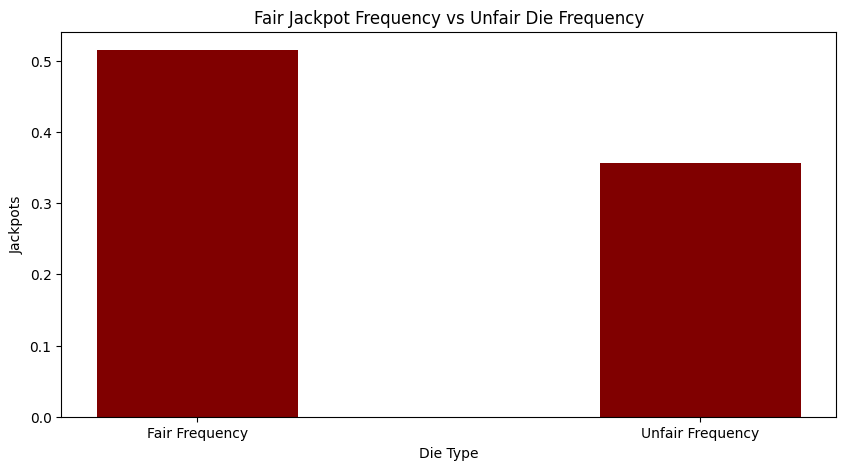

In [55]:
import matplotlib.pyplot as plt
data = {'Fair Frequency':fair_relative_freq, 'Unfair Frequency':unfair_relative_freq}
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)

plt.xlabel("Die Type")
plt.ylabel("Jackpots")
plt.title("Fair Jackpot Frequency vs Unfair Die Frequency")
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [59]:
die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
die3 = Die(np.array([1, 2, 3, 4, 5, 6]))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [62]:
die1.side_weight_change(6, 5)
die1.side_weight_change(5, 1)
die1.side_weight_change(4, 1)
die1.side_weight_change(3, 1)
die1.side_weight_change(2, 1)
die1.side_weight_change(1, 1)

In [63]:
die1._die

,side,weight
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,5.0


Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [64]:
die2.side_weight_change(6, 1)
die2.side_weight_change(5, 1)
die2.side_weight_change(4, 1)
die2.side_weight_change(3, 1)
die2.side_weight_change(2, 1)
die2.side_weight_change(1, 5)

In [65]:
die2._die

,side,weight
0,1,5.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0


Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [66]:
mylist = [die3, die3, die3, die3, die3]
diegame = Game(mylist)
diegame.play(1, 10000)
diegame.play(2, 10000)
diegame.play(3, 10000)
diegame.play(4, 10000)
diegame.play(5, 10000)

,die_1,die_2,die_3,die_4,die_5
roll_number,,,,,
1,5,5,5,5,4
2,5,5,5,6,1
3,5,4,5,3,1
4,3,6,2,6,2
5,3,6,6,4,6
...,...,...,...,...,...
9996,5,6,5,6,5
9997,5,6,1,6,5
9998,5,1,2,1,5


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [67]:
my_unfair_list = [die1, die1, die3, die3, die3]
diegame_unfair = Game(my_unfair_list)
diegame_unfair.play(1, 10000)
diegame_unfair.play(2, 10000)
diegame_unfair.play(3, 10000)
diegame_unfair.play(4, 10000)
diegame_unfair.play(5, 10000)

,die_1,die_2,die_3,die_4,die_5
roll_number,,,,,
1,2,3,5,1,5
2,6,4,4,4,1
3,6,6,6,3,4
4,2,1,5,4,1
5,6,6,6,1,2
...,...,...,...,...,...
9996,3,6,6,6,3
9997,6,3,6,6,3
9998,6,1,3,5,1


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

In [72]:
fairanalyzer = Analyzer(diegame)
fairfreq = fairanalyzer.jackpot()
fair_relative_freq = fairfreq / diegame._nrolls
fair_relative_freq

0.0011

In [73]:
unfairanalyzer = Analyzer(diegame_unfair)
unfairfreq = unfairanalyzer.jackpot()
unfair_relative_freq = unfairfreq / diegame_unfair._nrolls
unfair_relative_freq

0.0016

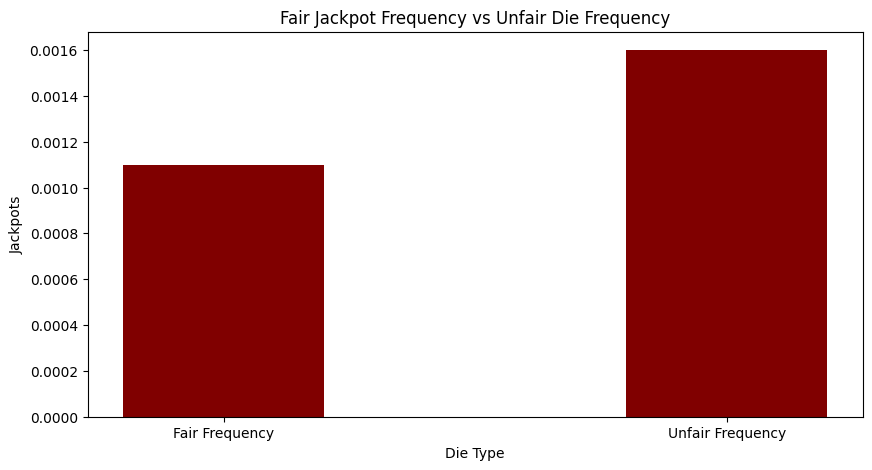

In [117]:
data = {'Fair Frequency':fair_relative_freq, 'Unfair Frequency':unfair_relative_freq}
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)

plt.xlabel("Die Type")
plt.ylabel("Jackpots")
plt.title("Fair Jackpot Frequency vs Unfair Die Frequency")
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [118]:
letters_df = pd.read_csv('english_letters.txt', delimiter=' ', header=None, names=['Letter', 'Frequency'])

In [126]:
letters_die = Die(np.array(list(letters_df['Letter'].values)))


,side,weight
0,E,0.038462
1,T,0.038462
2,A,0.038462
3,O,0.038462
4,I,0.038462
5,N,0.038462
6,S,0.038462
7,R,0.038462
8,H,0.038462
9,L,0.038462


In [127]:
for i in range(0, 26):
    letters_die.side_weight_change(letters_df['Letter'][i], letters_df['Frequency'][i])

In [128]:
letters_die._die

,side,weight
0,E,529117365.0
1,T,390965105.0
2,A,374061888.0
3,O,326627740.0
4,I,320410057.0
5,N,313720540.0
6,S,294300210.0
7,R,277000841.0
8,H,216768975.0
9,L,183996130.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [132]:
my_new_list = [letters_die, letters_die, letters_die, letters_die]
lettergame = Game(my_new_list)
lettergame.play(1, 1000)
lettergame.play(2, 1000)
lettergame.play(3, 1000)
lettergame.play(4, 1000)

,die_1,die_2,die_3,die_4
roll_number,,,,
1,O,H,A,S
2,E,K,R,M
3,E,I,F,R
4,T,A,D,A
5,E,M,L,S
...,...,...,...,...
996,H,A,D,S
997,T,O,R,O
998,T,E,W,E


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [152]:
letter_analyzer = Analyzer(lettergame)
letter_perm = letter_analyzer.perm_count()
letter_perm

993

In [144]:
words_df = pd.read_csv('scrabble_words.txt', header=None, names=['Word'])
words_df['Word']

0               AA
1              AAH
2            AAHED
3           AAHING
4             AAHS
            ...   
279491     ZYTHUMS
279492     ZYZZYVA
279493    ZYZZYVAS
279494         ZZZ
279495        ZZZS
Name: Word, Length: 279496, dtype: object

In [161]:
word_counter = 0
for each in letter_perm.index:
    merged = "".join(each)
    if merged in words_df['Word'].values:
        print(merged)
        word_counter += 1
len(letter_perm) - word_counter
    

INTO
MONA
DAHL
TEIN
LEAT
MITE
CERO
ERNE
GADE
ERGS
TIRE
TOLD
BATE
CLOT
DOEN
SETA
GEED
HASS
ETAS
MART
LERE
EARD
ALOE
HADS
TORO
NOON
LITS
NOLO
NESS
SESE
TATS
EATH
MEES
DINT
CIDE
CITE
REKE
DEIF
OLEA
CHER
TILL
FEST
METE
TERN
HARE
DIRT
GAIT
LEES
ACCA
ATES
ETAT
LASE
SARS


940

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [157]:
my_5_list = [letters_die, letters_die, letters_die, letters_die, letters_die]
five_lettergame = Game(my_5_list)
five_lettergame.play(1, 1000)
five_lettergame.play(2, 1000)
five_lettergame.play(3, 1000)
five_lettergame.play(4, 1000)
five_lettergame.play(5, 1000)

,die_1,die_2,die_3,die_4,die_5
roll_number,,,,,
1,R,U,I,R,T
2,T,E,E,E,R
3,H,A,G,C,S
4,E,R,T,B,S
5,N,T,T,N,U
...,...,...,...,...,...
996,R,E,I,D,E
997,B,O,R,E,M
998,T,A,D,N,T


In [158]:
five_letter_analyzer = Analyzer(five_lettergame)
five_letter_perm = five_letter_analyzer.perm_count()
five_letter_perm

,count
permutation,
"(R, U, I, R, T)",1
"(E, O, G, E, T)",1
"(O, D, U, T, I)",1
"(W, E, M, C, O)",1
"(I, T, E, U, T)",1
...,...
"(I, D, A, H, O)",1
"(E, D, M, T, R)",1
"(T, P, U, C, E)",1


In [160]:
five_word_counter = 0
for each in five_letter_perm.index:
    five_merged = "".join(each)
    if five_merged in words_df['Word'].values:
        print(five_merged)
        five_word_counter += 1
len(five_letter_perm) - five_word_counter

RANGE
SUERS
TAWAI
OTTOS
RAIAS
FERNS
EERIE
FILLO


992

The 4 word version found 60 words while the 5 word version found 8.